In [2]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, StringType
from graphframes import *

In [3]:
# Dados de carga
csv_pj = 'dataset/empresas_estabelecimentos_1m.csv'
csv_socios = 'dataset/socios_1m.csv'
checkpoint_dir = 'graphframes_cps_1m'
maior_cnpj = '04258527'
menor_cnpj = '03230095'

In [4]:
spark = SparkSession.builder \
        .config("spark.driver.memory", "128g") \
        .appName("gera_arvore1") \
        .getOrCreate()

sc = spark.sparkContext
sc.setCheckpointDir(checkpoint_dir)

23/12/12 22:42:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
# Schema para Json Empresa
json_schema_em = StructType([
    StructField("porteEmpresa", StringType(), True),
    StructField("capitalSocial", StringType(), True),
    StructField("cpfResponsavel", StringType(), True),
    StructField("nomeEmpresarial", StringType(), True),
    StructField("naturezaJuridica", StringType(), True),
    StructField("qualificacaoResponsavel", StringType(), True)
])

# Schema para Json Estabelecimento
json_schema_es = StructType([
    StructField("uf", StringType(), True),
    StructField("cep", StringType(), True),
    StructField("ddd1", StringType(), True),
    StructField("ddd2", StringType(), True),
    StructField("pais", StringType(), True),
    StructField("email", StringType(), True),
    StructField("bairro", StringType(), True),
    StructField("numero", StringType(), True),
    StructField("municipio", StringType(), True),
    StructField("telefone1", StringType(), True),
    StructField("telefone2", StringType(), True),
    StructField("cnaeFiscal", StringType(), True),
    StructField("logradouro", StringType(), True),
    StructField("complemento", StringType(), True),
    StructField("dataCadastro", StringType(), True),
    StructField("nomeFantasia", StringType(), True),
    StructField("cidadeExterior", StringType(), True),
    StructField("tipoLogradouro", StringType(), True),
    StructField("cnaesSecundarias", StringType(), True),
    StructField("situacaoEspecial", StringType(), True),
    StructField("situacaoCadastral", StringType(), True),
    StructField("dataSituacaoEspecial", StringType(), True),
    StructField("dataSituacaoCadastral", StringType(), True),
    StructField("motivoSituacaoCadastral", StringType(), True),
    StructField("identificadorMatrizFilial", StringType(), True)
])

# Definindo o esquema para leitura do CSV
schema = StructType([
    StructField("nu_cnpj_raiz", StringType(), True),
    StructField("te_dados_em", StringType(), True),
    StructField("id_estabelecimento", StringType(), True),
    StructField("te_dados_es", StringType(), True)
])

# Lendo o CSV com o esquema definido
pj = spark.read \
    .option("delimiter", ",") \
    .option("multiline", "true") \
    .option("escape", "\"") \
    .csv(csv_pj, schema=schema, header=True)

pj = pj.withColumn("te_dados_em", from_json(col("te_dados_em"), json_schema_em)) \
      .withColumn("te_dados_es", from_json(col("te_dados_es"), json_schema_es)) \
      .filter(substring(col("id_estabelecimento"), 0, 4) == '0001') \
      .withColumnRenamed("nu_cnpj_raiz", "id")

pj = pj.orderBy(col("id").asc()).dropDuplicates(['id'])

# verificando unidade de chaves:
# count_df = pj.groupBy('id').count()
# repeated_cnpj = count_df.filter(col('count') > 1)
# repeated_cnpj.show()

In [6]:
# Schema para Json Socios
json_schema_sc = StructType([
    StructField("pais", StringType(), True),
    StructField("entradaSociedade", StringType(), True),
    StructField("socioEstrangeiro", StringType(), True),
    StructField("qualificacaoSocio", StringType(), True),
    StructField("identificadorSocio", StringType(), True),
    StructField("cpfRepresentanteLegal", StringType(), True),
    StructField("qualificacaoRepresentanteLegal", StringType(), True)
])

# Definindo o esquema para leitura do CSV
schema = StructType([
    StructField("nu_cnpj_raiz", StringType(), True),
    StructField("id_socio", StringType(), True),
    StructField("te_dados_sc", StringType(), True)
])

# Lendo o CSV com o esquema definido
socio = spark.read \
        .option("delimiter", ",") \
        .option("multiline", "true") \
        .option("escape", "\"") \
        .csv(csv_socios, schema=schema, header=True)

# tratando o df socios
# Tratamento 1: Expandir o JSON
socio = socio.withColumn("te_dados_sc", from_json(col("te_dados_sc"), json_schema_sc))

# converte cnpj para nu_cnpj_raiz
socio = socio.withColumn("id_socio", when(socio["te_dados_sc"]["identificadorSocio"] == '1',
                                    socio["id_socio"].substr(1, 8))
                                .otherwise(socio["id_socio"]))
# Remomeia fonte e destino
socio = socio.withColumnRenamed("nu_cnpj_raiz", "src").withColumnRenamed("id_socio", "dst")
# Ordena por src, dst e remove arestas dubplicadas
socio = socio.orderBy(col("src").asc(), col("dst").asc()).dropDuplicates(['src', 'dst'])

In [7]:
# Cria df para vértices do tipo Pessoa Física:
pf = socio.filter(col("te_dados_sc.identificadorSocio") == '2').select(col("dst").alias("id")).distinct()

# Cria df para vértices de PJs que não foram exportados, mas estão no dst dos sócios
filtro = (col("te_dados_sc.identificadorSocio") == '1') & ((col("dst") > maior_cnpj) | (col("dst") < menor_cnpj))
pj_extra = socio.filter(filtro).select(col("dst").alias("id")).distinct()

cols_pj = [col_name for col_name in pj.columns if col_name != 'id']
for col_name in cols_pj:
    pf = pf.withColumn(col_name, lit(None))
    pj_extra = pj_extra.withColumn(col_name, lit(None))

# cria tipo de pessoa nos vértices
pj = pj.withColumn("id_tipoPessoa", lit(1))
pj_extra = pj_extra.withColumn("id_tipoPessoa", lit(1))
pf = pf.withColumn("id_tipoPessoa", lit(2))

# Cria tipo de relacionamento no socio
socio = socio.withColumn("id_tipoRel", lit(1))

pj = pj.union(pj_extra)
vertex = pj.union(pf).orderBy("id")

# verificando unidade de chaves:
# count_df = vertex.groupBy('id').count()
# repeated_vertex = count_df.filter(col('count') > 1)
# repeated_vertex.show()

In [8]:
# Criando o grafo de relacionamento empresas->socios
g = GraphFrame(vertex, socio)
g.cache()

23/12/12 22:42:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


GraphFrame(v:[id: string, te_dados_em: struct<porteEmpresa: string, capitalSocial: string ... 4 more fields> ... 3 more fields], e:[src: string, dst: string ... 2 more fields])

In [9]:
g_indegrees = g.inDegrees
most_connected = g.vertices.join(g_indegrees, "id").orderBy("inDegree", ascending=False).limit(10)

In [10]:
most_connected.show()

+--------------+-----------+------------------+-----------+-------------+--------+
|            id|te_dados_em|id_estabelecimento|te_dados_es|id_tipoPessoa|inDegree|
+--------------+-----------+------------------+-----------+-------------+--------+
|      01354636|       NULL|              NULL|       NULL|            1|      53|
|00070351392904|       NULL|              NULL|       NULL|            2|      47|
|00009188529860|       NULL|              NULL|       NULL|            2|      32|
|00003051537810|       NULL|              NULL|       NULL|            2|      32|
|      10436776|       NULL|              NULL|       NULL|            1|      26|
|00019395051868|       NULL|              NULL|       NULL|            2|      26|
|00077027604868|       NULL|              NULL|       NULL|            2|      24|
|      73178600|       NULL|              NULL|       NULL|            1|      23|
|00063408120153|       NULL|              NULL|       NULL|            2|      21|
|000

In [16]:
# chaves: 03235791, 73178600, 01354636
id = '19322044'

# Nós adjacentes 1 nível
# pFind = "(a)-[e]->(b)"
# pFilter = f"a.id = '{id}'"
# pSelect = "e.*"

# Nós adjacentes 1 nível
pFind = "(a)-[e]->(b)"

edges = g.find(pFind) \
          .filter(f"(a.id = '{id}') OR (b.id = '{id}')") \
          .select("e.*")
# edges.show()
v = edges.select("src").union(edges.select("dst")).distinct()
vertices = g.vertices.join(v, g.vertices["id"] == v["src"], "inner").select(g.vertices["*"])

In [21]:
edges.show()

+---+---+-----------+----------+
|src|dst|te_dados_sc|id_tipoRel|
+---+---+-----------+----------+
+---+---+-----------+----------+



In [17]:
# Converter os DataFrames do PySpark para DataFrames do Pandas
pandas_vertices = vertices.toPandas()
pandas_edges = edges.toPandas()

,src,dst,te_dados_sc,id_tipoRel


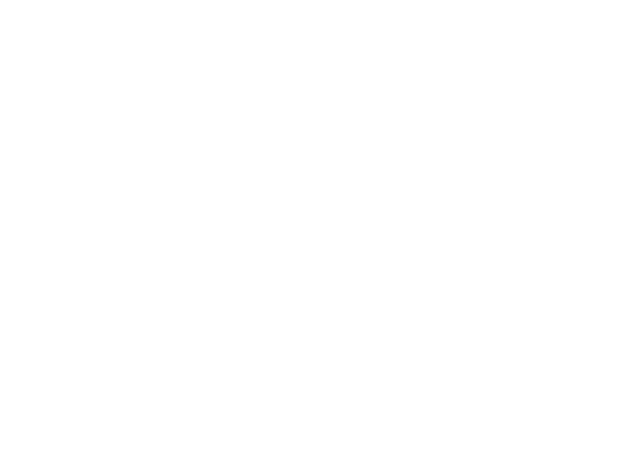

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Criar um grafo direcionado NetworkX
G = nx.DiGraph()

# Adicionar vértices e atribuir cores com base em 'id_tipoPessoa'
cores_vertices = pandas_vertices.set_index('id')['id_tipoPessoa'].to_dict()
G.add_nodes_from(pandas_vertices["id"].tolist())

# Adicionar arestas e atribuir cores com base em 'id_tipoRel'
cores_arestas = pandas_edges.set_index(['src', 'dst'])['id_tipoRel'].to_dict()
G.add_edges_from(pandas_edges[["src", "dst"]].values)

# Definir estilos e atributos visuais
pos = nx.circular_layout(G)  # Layout do grafo
largura_arestas = 2  # Largura das arestas

# Plotar os vértices com cores baseadas em 'id_tipoPessoa'
nx.draw_networkx_nodes(G, pos, node_color=[cores_vertices[n] for n in G.nodes()], cmap=plt.cm.tab10, node_size=300)

# Plotar as arestas com cores baseadas em 'id_tipoRel'
nx.draw_networkx_edges(G, pos, edge_color=[cores_arestas[(src, dst)] for src, dst in G.edges()], width=largura_arestas, alpha=0.5)

# Adicionar labels para 'id_tipoPessoa' igual a 1
labels = {n: n if cores_vertices[n] == 1 else '' for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=10)

# Mostrar o grafo com um layout mais bonito
plt.tight_layout()
plt.axis('off')
plt.show()


In [ ]:
spark.stop()